In [1]:
import sys
import os


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import RobustScaler,StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import importlib
from sklearn.decomposition import PCA

path_src = os.path.abspath('../../../src')

# Agregar esa ruta al sys.path si no está ya
if path_src not in sys.path:
    sys.path.append(path_src)

# Importar utils normalmente
import utils
importlib.reload(utils)

# Importar funciones específicas
from utils import (
    kmeans_clustering_mlflow,
    transform_pca,
    silhouette_analysis,
    elbow_method,
    plot_davies_bouldin_scores,
    evaluar_calinski_harabasz
)

In [2]:


ecommerce_data = pd.read_csv('../../../dataset/online_retail_clean.csv')

ecommerce_data.head()





,id_factura,id_producto,descripcion,cantidad,precio_unitario,id_cliente,pais,monto,dia,mes,anio,horario
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30,1,12,2010,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34,1,12,2010,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,22.00,1,12,2010,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,20.34,1,12,2010,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,20.34,1,12,2010,08:26:00


In [3]:
# filtrar los datos que no sean de Reino Unido
ecommerce_data_sin_uk = ecommerce_data[ecommerce_data['pais'] != 'United Kingdom'].copy()

# EXCLUIR PRODUCTOS ESPECIALES
ecommerce_data_sin_uk = ecommerce_data_sin_uk[~ecommerce_data_sin_uk['id_producto'].isin(['PADS', 'DOT', 'M','C2', 'POST', 'BANK CHARGES'])]

In [4]:
cantidad_clientes_extranjeros = ecommerce_data_sin_uk['id_cliente'].nunique()

print(cantidad_clientes_extranjeros)

418


In [5]:
cantidad_productos_extranjeros = ecommerce_data_sin_uk['id_producto'].nunique()

print(cantidad_productos_extranjeros)

2781


In [6]:
productos_clusters=pd.read_csv('../../../dataset/productos_cluster_extranjeros.csv')

productos_clusters.head()





,id_producto,Cluster
0,10120,0
1,10125,2
2,10133,1
3,10135,2
4,11001,0


In [7]:
clientes_clusters=pd.read_csv('../../../dataset/clientes_cluster_extranjeros.csv')

clientes_clusters.head()

,id_cliente,Cluster
0,12348.0,2
1,12349.0,2
2,12350.0,0
3,12352.0,1
4,12353.0,0


In [8]:


print(clientes_clusters.columns)

print(productos_clusters.columns)

print(ecommerce_data_sin_uk.columns)

Index(['id_cliente', 'Cluster'], dtype='object')
Index(['id_producto', 'Cluster'], dtype='object')
Index(['id_factura', 'id_producto', 'descripcion', 'cantidad',
       'precio_unitario', 'id_cliente', 'pais', 'monto', 'dia', 'mes', 'anio',
       'horario'],
      dtype='object')


In [9]:
# Renombrar columnas de cluster para evitar colisiones
clientes_clusters = clientes_clusters.rename(columns={'Cluster': 'cluster_cliente'})
productos_clusters = productos_clusters.rename(columns={'Cluster': 'cluster_producto'})

# Hacer merge de ecommerce_data_sin_uk con clientes_clusters
df_merged = ecommerce_data_sin_uk.merge(clientes_clusters, on='id_cliente', how='left')

# Luego merge con productos_clusters
df_merged = df_merged.merge(productos_clusters, on='id_producto', how='left')

# Eliminar filas donde no se encontró cluster de cliente o producto
df_merged = df_merged.dropna(subset=['cluster_cliente', 'cluster_producto'])

# (Opcional) Resetear el índice
df_merged = df_merged.reset_index(drop=True)

# Mostrar resultado
df_merged.head(10)


,id_factura,id_producto,descripcion,cantidad,precio_unitario,id_cliente,pais,monto,dia,mes,anio,horario,cluster_cliente,cluster_producto
0,536858,20677,PINK POLKADOT BOWL,16,1.25,13520.0,Switzerland,20.00,3,12,2010,10:36:00,1.0,2.0
1,536861,22149,FELTCRAFT 6 FLOWER FRIENDS,6,2.10,12427.0,Germany,12.60,3,12,2010,10:44:00,2.0,2.0
2,536861,22301,COFFEE MUG CAT + BIRD DESIGN,6,2.55,12427.0,Germany,15.30,3,12,2010,10:44:00,2.0,0.0
3,536861,22300,COFFEE MUG DOG + BALL DESIGN,6,2.55,12427.0,Germany,15.30,3,12,2010,10:44:00,2.0,0.0
4,536861,21328,BALLOONS WRITING SET,12,1.65,12427.0,Germany,19.80,3,12,2010,10:44:00,2.0,0.0
5,536861,21329,DINOSAURS WRITING SET,12,1.65,12427.0,Germany,19.80,3,12,2010,10:44:00,2.0,0.0
6,537218,21506,"FANCY FONT BIRTHDAY CARD,",12,0.42,12763.0,Japan,5.04,5,12,2010,15:46:00,0.0,0.0
7,537218,22983,CARD BILLBOARD FONT,12,0.42,12763.0,Japan,5.04,5,12,2010,15:46:00,0.0,0.0
8,537218,22030,SWALLOWS GREETING CARD,12,0.42,12763.0,Japan,5.04,5,12,2010,15:46:00,0.0,0.0
9,537218,22984,CARD GINGHAM ROSE,12,0.42,12763.0,Japan,5.04,5,12,2010,15:46:00,0.0,2.0


### tabla de contigencia entre cluster de producto y clientes

In [10]:
tabla_conexiones = pd.crosstab(df_merged['cluster_cliente'], df_merged['cluster_producto'])

tabla_conexiones

cluster_producto,0.0,1.0,2.0
cluster_cliente,,,
0.0,431,148,505
1.0,1194,215,1377
2.0,1357,154,1382


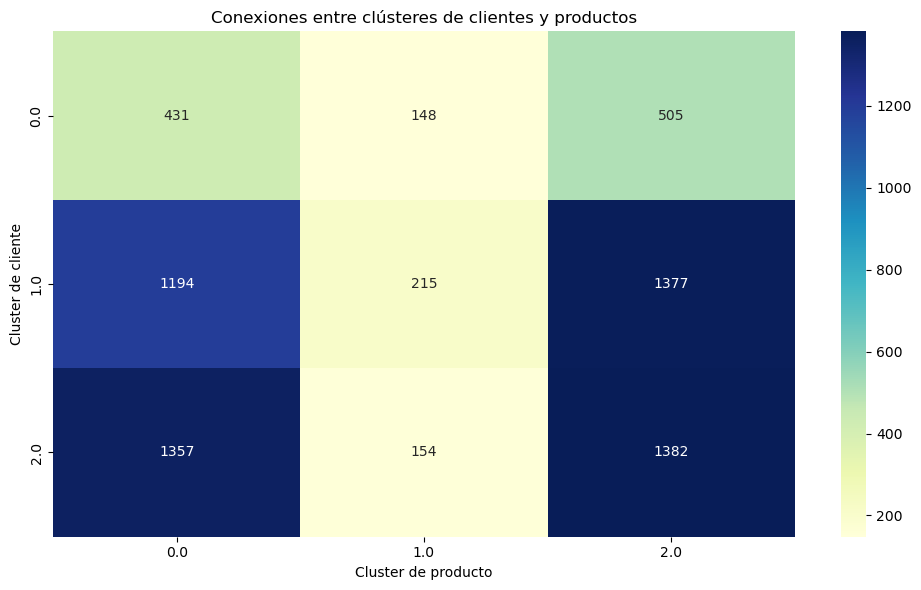

In [11]:

plt.figure(figsize=(10, 6))
sns.heatmap(tabla_conexiones, annot=True, fmt='d', cmap='YlGnBu')

plt.title("Conexiones entre clústeres de clientes y productos")
plt.xlabel("Cluster de producto")
plt.ylabel("Cluster de cliente")
plt.tight_layout()
plt.show()


### GASTO DE LOS CLUESTER DE CLIENTES EN CADA CLUSTER DE PRODUCTO

In [12]:
# Agrupar por clúster de cliente y producto, y sumar el monto total
conexiones_monto = df_merged.groupby(['cluster_cliente', 'cluster_producto'])['monto'].sum().unstack(fill_value=0)

# Mostrar la tabla
print(conexiones_monto)


cluster_producto       0.0      1.0       2.0
cluster_cliente                              
0.0                7715.57  2879.86  10003.77
1.0               22315.67  3955.58  24705.02
2.0               19341.72  2606.45  21834.92


/tmp/ipykernel_6061/339071380.py:10: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/agustin/miniconda3/envs/ecommerce/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


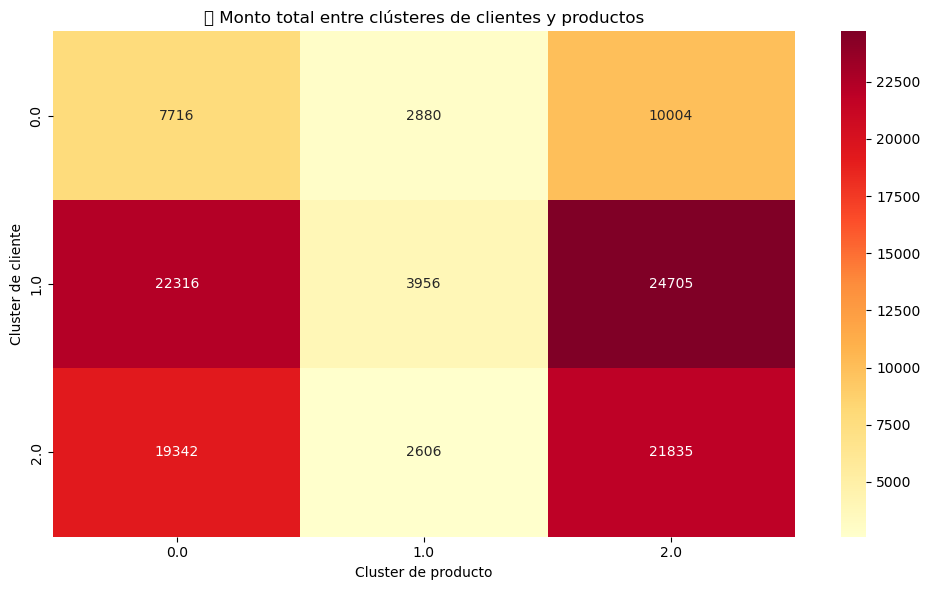

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(conexiones_monto, annot=True, fmt='.0f', cmap='YlOrRd')

plt.title("💰 Monto total entre clústeres de clientes y productos")
plt.xlabel("Cluster de producto")
plt.ylabel("Cluster de cliente")
plt.tight_layout()
plt.show()


In [14]:
# Resetear índice para trabajar más fácilmente
top_conexiones = df_merged.groupby(['cluster_cliente', 'cluster_producto'])['monto'].sum().reset_index()

# Ordenar de mayor a menor monto
top_conexiones = top_conexiones.sort_values(by='monto', ascending=False)

print(top_conexiones.head(5))


   cluster_cliente  cluster_producto     monto
5              1.0               2.0  24705.02
3              1.0               0.0  22315.67
8              2.0               2.0  21834.92
6              2.0               0.0  19341.72
2              0.0               2.0  10003.77


### CANTIDAD DE CADA UNIDADES QUE SE LLEVAN DE CADA CLUSTER DE PRODUCTOS POR CADA CLUSTER DE CLIENTE

In [15]:
# Agrupar por clúster de cliente y producto, y sumar la cantidad total
conexiones_cantidad = df_merged.groupby(['cluster_cliente', 'cluster_producto'])['cantidad'].sum().unstack(fill_value=0)

# Mostrar tabla
print(conexiones_cantidad)


cluster_producto    0.0   1.0    2.0
cluster_cliente                     
0.0                3552  1834   6362
1.0               14508  2401  19701
2.0               12180  1514  18059


/tmp/ipykernel_6061/1605888141.py:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/agustin/miniconda3/envs/ecommerce/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


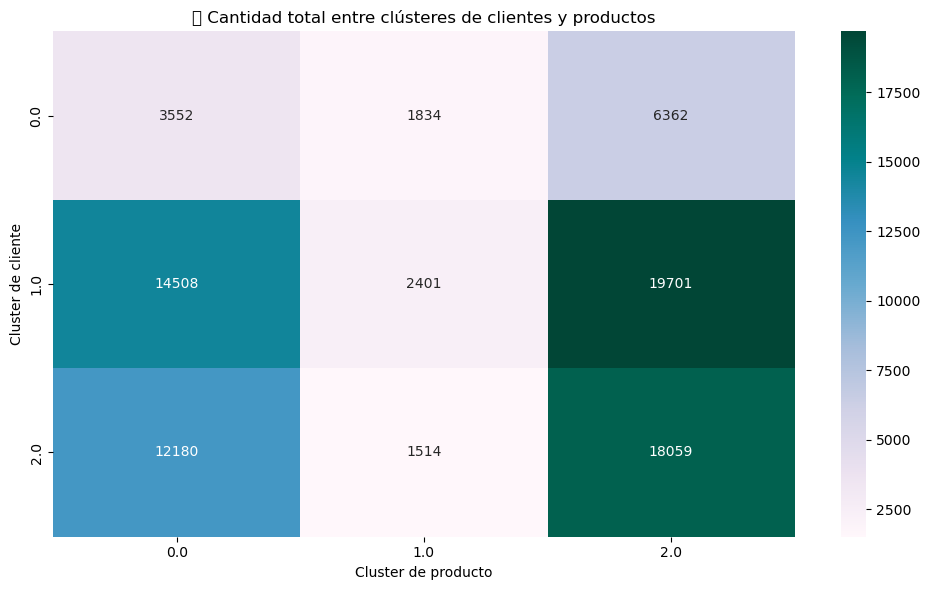

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(conexiones_cantidad, annot=True, fmt='.0f', cmap='PuBuGn')

plt.title("📦 Cantidad total entre clústeres de clientes y productos")
plt.xlabel("Cluster de producto")
plt.ylabel("Cluster de cliente")
plt.tight_layout()
plt.show()


In [17]:
top_cantidades = df_merged.groupby(['cluster_cliente', 'cluster_producto'])['cantidad'].sum().reset_index()

top_cantidades = top_cantidades.sort_values(by='cantidad', ascending=False)

print(top_cantidades.head(5))


   cluster_cliente  cluster_producto  cantidad
5              1.0               2.0     19701
8              2.0               2.0     18059
3              1.0               0.0     14508
6              2.0               0.0     12180
2              0.0               2.0      6362


In [18]:
df_merged.head()

,id_factura,id_producto,descripcion,cantidad,precio_unitario,id_cliente,pais,monto,dia,mes,anio,horario,cluster_cliente,cluster_producto
0,536858,20677,PINK POLKADOT BOWL,16,1.25,13520.0,Switzerland,20.0,3,12,2010,10:36:00,1.0,2.0
1,536861,22149,FELTCRAFT 6 FLOWER FRIENDS,6,2.10,12427.0,Germany,12.6,3,12,2010,10:44:00,2.0,2.0
2,536861,22301,COFFEE MUG CAT + BIRD DESIGN,6,2.55,12427.0,Germany,15.3,3,12,2010,10:44:00,2.0,0.0
3,536861,22300,COFFEE MUG DOG + BALL DESIGN,6,2.55,12427.0,Germany,15.3,3,12,2010,10:44:00,2.0,0.0
4,536861,21328,BALLOONS WRITING SET,12,1.65,12427.0,Germany,19.8,3,12,2010,10:44:00,2.0,0.0


# CONCLUSIÓN


Se aplicó K-means para segmentar tanto a los clientes como a los productos, obteniendo tres clústeres por cada grupo. Posteriormente, se cruzaron los clústeres en una matriz para analizar el monto total y la cantidad total de compras. Este análisis se complementó con variables RFM (Recencia, Frecuencia, Monto), evolución temporal de las ventas y comportamiento por país.


## 1. Perfilado de los clusteres de clientes


| Clúster | Recencia | Frecuencia | Monto | Característica principal                                                   |
| ------- | -------- | ---------- | ----- | -------------------------------------------------------------------------- |
| 0       | 228     | 1         |     739| Clientes poco frecuentes y recientes. Bajo valor total.                    |
| 1       | 36    | 4       | 2336  | Clientes muy activos y con alto gasto. Son el principal motor de ingresos. |
| 2       | 50     | 2      | 688 | Clientes antiguos pero que mantienen actividad estable.                    |


## 2. Perfilado de los clusteres de producto

| Clúster | Recency | Frequency  | Monetary  | Interpretación                                                                                                                  |
| ------- | ----------------- | ------------------- | ------------------ | ------------------------------------------------------------------------------------------------------------------------------- |
| **0**   | 26.3              | 83.96               | 145.29             | Productos de **alta rotación** pero de **bajo valor por venta**. Son productos funcionales o de consumo masivo.                 |
| **1**   | 121.5             | 47.63               | 74.65              | Productos con **recencia muy alta** y **frecuencia baja**, de **muy bajo valor**. Son productos probablemente **rezagados**.    |
| **2**   | 19.9              | 403.55              | 528.83             | Productos con **recencia excelente**, **altísima rotación** y **alto valor**. Son los productos **estrella** o **top sellers**. |


## 3. Análisis cruzado entre clústeres basado en los mapas de calor

- El clúster de clientes 1 y productos 2 genera el mayor monto total (24.705) y la mayor cantidad de compras (19.701) → segmento estratégico.

- El clúster de clientes 2 y productos 2 también es fuerte en monto (21.835) y cantidad (18.059).

- El clúster de clientes 1 y productos 0 también sobresale (22.316 de monto y 14.508 en cantidad), lo que lo convierte en un grupo secundario de alto valor.

## 4. Recomendaciones de marketing Personalizadas 

### Grupo 1

Clientes del clúster 1 y productos del clúster 2 , aqui esta el mayor ingreso de la parte extranjera 


Acciones:

   - Programas de asociacion con tarjetas que brinden descuentos.

   - Ofertas exclusivas para lanzamientos o ediciones limitadas.

   - Comunicación frecuente por mail con novedades.


### Grupo 2

Clientes del clúster 2 y productos del clúster 2 (clientes nuevos con productos de baja rotación)

Acciones:

 - Promociones tipo 2x1 o prueba gratis.

 - Campañas de remarketing.

 - Reforzar contenido y reseñas de productos.

### Grupo 3

Clientes del clúster 1 y productos del clúster 0 (clientes veteranos con productos estrella)

Acciones:

  - paquetes promocionales.

  - Promociones “comeback” para aumentar frecuencia.



## 5. Consideracion por pais 

###  Estrategias regionales basadas en ventas promedio por país

Del análisis realizado, se identificaron diferencias importantes en el rendimiento de los productos según el país. A continuación, se propone una estrategia de promoción segmentada por clúster de producto, teniendo en cuenta que **el orden de los países refleja la prioridad**, ya que están listados según el **mayor promedio de ventas** de ese clúster.



####  Productos del *clúster 2* 

Se recomienda priorizar su promoción en los siguientes países:

1. **Países Bajos (Holanda)**
2. **Alemania**
3. **Irlanda**
4. **Francia**





####  Productos del *clúster 1* 

A pesar de su bajo rendimiento general, hay países donde aún conservan cierta tracción. Se recomienda focalizar esfuerzos de promoción en:

1. **Irlanda**
2. **Alemania**
3. **Holanda**
4. **Francia**

.

####  Productos del *clúster 0* 

Estos productos presentan buena rotación, aunque con bajo monto por unidad. Se recomienda potenciar su presencia en los siguientes países:

1. **Irlanda**
2. **Alemania**
3. **Francia**
4. **Holanda**









## 6. Evolucion Temporal

### Análisis cruzado de comportamiento mensual

####  Gasto Promedio Mensual por Clúster de Cliente

- **Clúster 1** domina el gasto mensual, con picos en junio, octubre y noviembre.  
  → Perfil VIP, leal y con alto poder adquisitivo.


- **Clúster 0** arranca bien pero cae desde julio.  
  → Clientes que abandonan o reducen actividad.


- **Clúster 2** muestra crecimiento estable hasta octubre.  
  → Segmento en expansión o fidelizable.

####  Ventas Promedio Mensual por Clúster de Producto

- **Clúster 2** (productos estrella) lidera durante todo el año, con picos en sep-oct-nov.  

- **Clúster 1** se mantiene bajo y desaparece desde octubre.  

- **Clúster 0** es constante, con leve aumento en octubre.  



